<a href="https://colab.research.google.com/github/Ajwad07/ML_projects_2025/blob/main/AE_Cifar10_Linear_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



In [49]:
# 1. Data transforms for CIFAR-10 (normalize to [0,1] or [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [50]:
# 2. Load CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



In [51]:
len(test_dataset)

10000

In [60]:
# 3. Define an Autoencoder for CIFAR-10 (flatten 32x32x3 = 3072)
class Autoencoderbig(nn.Module):
    def __init__(self):
        super(Autoencoderbig, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(), #this is why no flattening needed in train loop
            nn.Linear(32*32*3, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256,128),
            nn.ReLU(True),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32*32*3),
            nn.Tanh()  # Because we normalized to [-1,1]
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 3, 32, 32)
        return x



class Autoencodersmall(nn.Module):
    def __init__(self):
        super(Autoencodersmall, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32*32*3),
            nn.Tanh()  # Because we normalized to [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 3, 32, 32)
        return x

model = Autoencoderbig().cuda() if torch.cuda.is_available() else Autoencoderbig()



Epoch:1, Loss:0.17728166282176971
Epoch:2, Loss:0.17254149913787842
Epoch:3, Loss:0.15929824113845825
Epoch:4, Loss:0.15692256391048431
Epoch:5, Loss:0.14875821769237518
Epoch:6, Loss:0.13663089275360107
Epoch:7, Loss:0.12946094572544098
Epoch:8, Loss:0.12542209029197693
Epoch:9, Loss:0.12392326444387436
Epoch:10, Loss:0.121578149497509
Epoch:11, Loss:0.11795841157436371
Epoch:12, Loss:0.11170687526464462
Epoch:13, Loss:0.10901715606451035
Epoch:14, Loss:0.10662253201007843
Epoch:15, Loss:0.10335873812437057
Epoch:16, Loss:0.10010068118572235
Epoch:17, Loss:0.09552275389432907
Epoch:18, Loss:0.0929446667432785
Epoch:19, Loss:0.08905716240406036
Epoch:20, Loss:0.08687475323677063


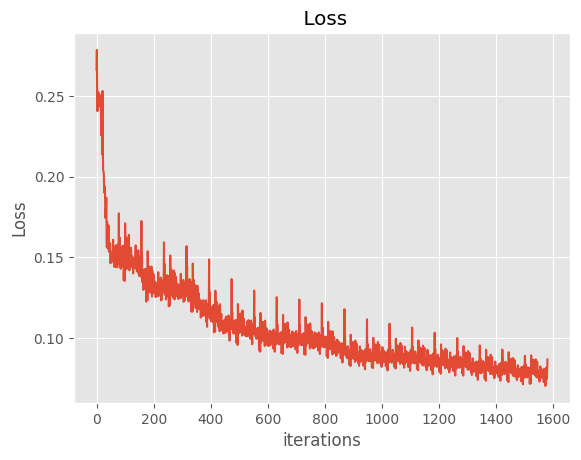

In [61]:
# 4. Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002,weight_decay=1e-9)

op=[]
losses=[]

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# 5. Training loop (simplified)
num_epochs = 20
for epoch in range(num_epochs):
    for data in test_loader:
        imgs, _ = data
        imgs = imgs.cuda() if torch.cuda.is_available() else imgs #images=images.view(-1,28*28*1).to(device) -> needs when the model has no flatten and -1 refers to batch size <----> refer to 1st layer of enocder
        # Forward
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        op.append((epoch,imgs,outputs))
    print(f"Epoch:{epoch+1}, Loss:{loss.item()}")

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(losses)
plt.title(" Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

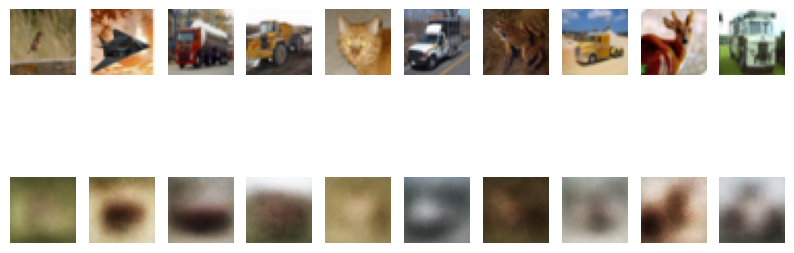

In [62]:
model.eval()
dataiter=iter(train_loader)
images,_=next(dataiter)
# Reshape images to the correct flattened size for CIFAR-10 (32*32*3)
# The -1 lets torch infer the batch size
images = images.view(-1, 32*32*3).to(device)
reconstructed=model(images)
# Denormalize from [-1, 1] to [0, 1]
images_show = (images.cpu().detach().numpy() + 1) / 2
reconstructed_show = (reconstructed.cpu().detach().numpy() + 1) / 2

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(10, 4))
for i in range(10):
    # Original images
    axes[0][i].imshow(images_show[i].reshape(3, 32, 32).transpose(1, 2, 0))
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1][i].imshow(reconstructed_show[i].reshape(3, 32, 32).transpose(1, 2, 0))
    axes[1, i].axis('off')
plt.show()


In [27]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # 1. Data transforms for CIFAR-10 (normalize to [0,1] or [-1,1])
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # 2. Load CIFAR-10
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# # 3. Define an Autoencoder for CIFAR-10 (flatten 32x32x3 = 3072)
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(32*32*3, 1024),
#             nn.ReLU(True),
#             nn.Linear(1024, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 64)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 1024),
#             nn.ReLU(True),
#             nn.Linear(1024, 32*32*3),
#             nn.Tanh()  # Because we normalized to [-1,1]
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         x = x.view(-1, 3, 32, 32)
#         return x

# model = Autoencoder().cuda() if torch.cuda.is_available() else Autoencoder()

# # 4. Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # 5. Training loop (simplified)
# num_epochs = 10
# for epoch in range(num_epochs):
#     for data in train_loader:
#         imgs, _ = data
#         imgs = imgs.cuda() if torch.cuda.is_available() else imgs
#         # Forward
#         outputs = model(imgs)
#         loss = criterion(outputs, imgs)
#         # Backward
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")